In [1456]:
import os
import operator
from dotenv import load_dotenv
from typing import Annotated, List, Optional, Dict, Literal
from typing_extensions import TypedDict
from IPython.display import Image, Markdown
import markdown2
import json
import requests
from datetime import datetime, timedelta

from pydantic import BaseModel, Field, field_validator
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage
from langgraph.graph import StateGraph, START, END
from langchain_core.tools import tool
from langchain_tavily import TavilySearch



load_dotenv()
groq_api_key = os.getenv("GROQ_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY")
llm = ChatGroq(model="llama3-70b-8192", api_key = groq_api_key)


In [1457]:
class TripRequest(BaseModel) :
    """Schema for user's travel requests."""
    origin: str = Field(description="The departure city for the trip.")
    destination: str = Field(description="The arrival city for the trip.")
    start_date: str = Field(description="The start date of the trip in YYYY-MM-DD format.")
    end_date: str = Field(description="The end date of the trip in YYYY-MM-DD format.")
    person: int = Field(description="The total number of people participating in the trip.")
    budget: Optional[float] = Field(description="The estimated budget for the trip.")
    interests: Optional[List[str]] = Field(description="A list of interests for the trip, e.g., ['art', 'history', 'food'].")

    @property
    def days(self) -> int:
        start = datetime.strptime(self.start_date, "%Y-%m-%d")
        end = datetime.strptime(self.end_date, "%Y-%m-%d")
        return (end - start).days + 1
    

In [1458]:
class FlightInfo(BaseModel) :
    """Schema for flight information"""
    airline : str = Field(description= "The name of the airline")
    price : float = Field(description= "The price of the round-trip flight")
    origin : str = Field(description= "The departure city")
    destination : str = Field(description= "The arrival city")
    duration_minutes: int = Field(description="The total duration of the flight in minutes.") 


class FlightSelection(BaseModel):
    """Schema for the selected flight."""
    best_option_index: int = Field(description="The index (starting from 0) of the best flight option from the provided list.")
    reasoning: str = Field(description="A brief explanation of why this option was chosen.")


class HotelInfo(BaseModel):
    """Schema for hotel information."""
    hotel_name: str = Field(description="The name of the hotel.")
    price_per_night: float = Field(description="The price per night.")
    total_price: float = Field(description="The total price for the entire stay.")
    rating: float = Field(description="The hotel's rating out of 9.")


class HotelSelection(BaseModel):
    """Schema for the selected hotel."""
    best_option_index: int = Field(description="The index (starting from 0) of the best hotel option from the provided list.")
    reasoning: str = Field(description="A brief explanation of why this hotel was chosen, balancing price and rating.")


class Activity(BaseModel):
    """Schema for a single activity."""
    name: str = Field(description="Name of the activity or place.")
    description: str = Field(description="A brief description of the activity.")
    location: str = Field(description="Location or address of the activity.")
    time_of_day: str = Field(description="Suggested time of day, e.g., 'Morning', 'Afternoon', 'Evening'.")


class DailyPlan(BaseModel):
    """Schema for a single day's plan."""
    day: int = Field(description="The day number (e.g., 1, 2, 3).")
    activities: List[Activity] = Field(description="A list of activities for the day.")



class Itinerary(BaseModel):
    """The complete, final itinerary for the trip."""
    selected_flight: FlightInfo
    selected_hotel: HotelInfo
    daily_plans: List[DailyPlan]


class EvaluationResult(BaseModel):
    """Schema for the evaluation result."""
    action: Literal["APPROVE", "REFINE_HOTEL", "REFINE_FLIGHT"] = Field(description="Action to take.")
    feedback: str = Field(description="Feedback on the plan, explaining the reason for the action.")
    total_cost: float = Field(description="The calculated total cost of the trip.")

In [1459]:
@tool
def iata_finder_tool(city_name: str) -> List[str]:
    """
    Finds the IATA codes for a given city name using the Booking-com18 auto-complete endpoint.
    Returns a list of relevant airport IATA codes.
    """
    print(f"--- Calling Booking.com auto-complete API for {city_name} ---")
    
    url = "https://booking-com18.p.rapidapi.com/flights/v2/auto-complete"
    querystring = {"query": city_name}
    headers = {
        "x-rapidapi-key": os.getenv("RAPIDAPI_KEY"),
        "x-rapidapi-host": "booking-com18.p.rapidapi.com"
    }
    
    try:
        response = requests.get(url, headers=headers, params=querystring)
        response.raise_for_status()
        data = response.json()
        
        iata_codes = []
        if data.get('data'):
            for location in data['data']:
                if location.get('type') == 'AIRPORT':
                    iata_codes.append(location['code'])
        
        if not iata_codes:
            print(f"-> No IATA codes found for {city_name}")
            return []
            
        print(f"-> Found IATA codes for {city_name}: {iata_codes}")
        return iata_codes
        
    except requests.exceptions.RequestException as e:
        print(f"-> IATA Finder API request failed: {e}")
        return []


@tool
def flight_search_tool(origin_iata_list: List[str], destination_iata_list: List[str], start_date: str, end_date: str, person: int, origin_city: str, destination_city: str) -> List[FlightInfo]:
    """
    Searches for flights for all given airport IATA codes and returns a sorted list of options.
    """

    print(f"--- Calling REAL Flight API for {origin_iata_list} -> {destination_iata_list} ---")

    all_flight_options = []

    for origin_iata in origin_iata_list:
        for destination_iata in destination_iata_list:

            print(f"-> Searching flights from {origin_iata} to {destination_iata}...")

            url = "https://booking-com18.p.rapidapi.com/flights/v2/search-roundtrip"

            querystring = {
                "departId": origin_iata, "arrivalId": destination_iata, "departDate": start_date,
                "returnDate": end_date, "adults": str(person), "sort": "CHEAPEST", "currency_code": "EUR"
            }

            headers = {
                "x-rapidapi-key": os.getenv("RAPIDAPI_KEY"),
                "x-rapidapi-host": "booking-com18.p.rapidapi.com"
            }

            try:
                response = requests.get(url, headers=headers, params=querystring)
                response.raise_for_status()
                data = response.json()

                if data.get('data') and data['data'].get('flightOffers'):
                    for flight_offer in data['data']['flightOffers']:

                        price_info = flight_offer['priceBreakdown']['total']
                        total_price = price_info.get('units', 0) + price_info.get('nanos', 0) / 1_000_000_000
                        airline = flight_offer['segments'][0]['legs'][0]['carriersData'][0]['name']
                        duration_seconds_outbound = flight_offer['segments'][0].get('totalTime', 0)
                        duration_seconds_return = flight_offer['segments'][1].get('totalTime', 0)
                        total_duration_minutes = (duration_seconds_outbound + duration_seconds_return) // 60
                
                        all_flight_options.append(FlightInfo(
                            airline=airline,
                            price=total_price,
                            origin=f"{origin_city} ({origin_iata})", 
                            destination=destination_city,
                            duration_minutes=total_duration_minutes
                        ))

            except requests.exceptions.RequestException as e:

                print(f"-> API request failed for {origin_iata} -> {destination_iata}: {e}")
                continue

    if not all_flight_options:
        print("-> No flights found for any airport combinations.")
        return []

    all_flight_options.sort(key=lambda x: x.price)

    print(f"-> Found a total of {len(all_flight_options)} flights. Returning the top 5 cheapest.")

    return all_flight_options[:5]





@tool
def location_id_finder_tool(city_name: str) -> Optional[str]:
    """
    Finds the specific locationId for a city using the Booking.com Stays auto-complete API.
    Returns the ID for the first and most relevant result.
    """
    print(f"--- Calling Location ID Finder API for {city_name} ---")
    
    url = "https://booking-com18.p.rapidapi.com/stays/auto-complete"

    querystring = {"query": city_name}
    headers = {
        "x-rapidapi-key": os.getenv("RAPIDAPI_KEY"),
        "x-rapidapi-host": "booking-com18.p.rapidapi.com"
    }
    
    try:
        response = requests.get(url, headers=headers, params=querystring)
        response.raise_for_status()
        data = response.json()
        
        
        if data.get('data') and len(data['data']) > 0:
            location_id = data['data'][0].get('id')
            if location_id:
                print(f"-> Found Location ID for {city_name}: {location_id}")
                return location_id
        
        print(f"-> No Location ID found for {city_name}")
        return None
        
    except requests.exceptions.RequestException as e:
        print(f"-> Location ID Finder API request failed: {e}")
        return None


@tool
def hotel_search_tool(location_id: str, start_date: str, end_date: str, person: int) -> List[HotelInfo]:
    """
    Searches for top hotels using a pre-fetched locationId from the Booking.com Stays API.
    """
    print(f"--- Calling REAL Booking.com Hotel API with Location ID: {location_id[:30]}... ---")

    
    url = "https://booking-com18.p.rapidapi.com/stays/search"
    querystring = {
        "locationId": location_id,
        "checkinDate": start_date,
        "checkoutDate": end_date,
        "adults": str(person),
        "sortBy": "bayesian_review_score", 
        "currencyCode": "EUR"
    }
    headers = {
        "x-rapidapi-key": os.getenv("RAPIDAPI_KEY"),
        "x-rapidapi-host": "booking-com18.p.rapidapi.com"
    }

    try:
        response = requests.get(url, headers=headers, params=querystring)
        response.raise_for_status()
        data = response.json()

        if not data.get('data'):
            print("-> No hotels found in the API response.")
            return []

        results = []
        num_nights = (datetime.strptime(end_date, "%Y-%m-%d") - datetime.strptime(start_date, "%Y-%m-%d")).days
        for hotel_data in data['data'][:3]: # En iyi 3 oteli al
            total_price = hotel_data.get('priceBreakdown', {}).get('grossPrice', {}).get('value', 0)
            price_per_night = total_price / num_nights if num_nights > 0 else 0
            results.append(
                HotelInfo(
                    hotel_name=hotel_data.get('name', 'Unknown Hotel'),
                    price_per_night=round(price_per_night, 2),
                    total_price=total_price,
                    rating=hotel_data.get('reviewScore', 0)
                )
            )
        
        print(f"-> Found {len(results)} hotel options from API.")
        return results

    except requests.exceptions.RequestException as e:
        print(f"-> API request failed: {e}")
        return []




@tool
def activity_finder_tool(destination: str, interests: List[str]) -> str:
    """
    Performs targeted Tavily searches, correctly parses the dictionary response,
    and returns a consolidated summary string.
    """
    print(f"--- Calling Tavily Search with targeted queries for {destination} ---")
    
    all_results_summary = ""
    tavily_search = TavilySearch(max_results=3)

    for interest in interests:
        query = f"specific and famous '{interest}' places, landmarks, or experiences in {destination}. Give me names of places, not tours."
        print(f"-> Searching for: {query}")
        
        
        response_dict = tavily_search.invoke(query)
        
        search_results = response_dict.get('results', [])
        
        all_results_summary += f"\n--- Search Results for '{interest}' in {destination} ---\n"
        
        if not search_results:
            all_results_summary += "No specific results found for this interest.\n\n"
            continue

        for result in search_results:
            all_results_summary += f"Title: {result.get('title', 'N/A')}\nContent: {result.get('content', 'No content')}\n\n"

    return all_results_summary




In [1460]:
class TripState(TypedDict):
    user_request: str
    trip_plan: Optional[TripRequest]
    selected_flight: Optional[FlightInfo] 
    flight_options: List[FlightInfo] 
    selected_hotel: Optional[HotelInfo]
    hotel_options: List[HotelInfo]
    final_itinerary: Optional[Itinerary]
    evaluation_result: Optional[EvaluationResult] 
    refinement_count: int 
    markdown_report: Optional[str]

In [1461]:
def planner_agent(state: TripState) -> dict:
    """
    Takes the user request and converts it into a structured TripRequest object
    using the robust .bind_tools() method.
    """
    print("--- Running Planner Agent ---")
    
    planner_llm = llm.bind_tools([TripRequest])
    
    prompt = f"""
    You are an expert at parsing user travel requests.
    Parse the following user request into a structured TripRequest object.
    Extract the origin, destination, start date, end date, number of people, budget, and key interests.
    Today's date is {datetime.now().strftime('%Y-%m-%d')}. Dates must be in YYYY-MM-DD format.

    User Request: "{state['user_request']}"
    """
    
    ai_message = planner_llm.invoke(prompt)
    
    if not ai_message.tool_calls:
        raise ValueError("Planner agent failed to parse the user request into a structured plan.")
        
    tool_call = ai_message.tool_calls[0]
    plan = TripRequest(**tool_call['args'])
    
    print(f"-> Structured Plan: {plan}")
    
    return {"trip_plan": plan, "refinement_count": 0}


In [1462]:
def flight_agent(state: TripState) -> dict:
    """
    Orchestrates the flight search: finds IATA codes, then finds flight options,
    and finally uses an LLM to make an intelligent selection.
    """
    print("--- Running Flight Agent ---")

    trip_plan = state['trip_plan']

    if not trip_plan:
         return {}

    print("-> Step 1: Finding IATA codes...")

    origin_iatalist = iata_finder_tool.invoke(trip_plan.origin)
    destination_iatalist = iata_finder_tool.invoke(trip_plan.destination)

    if not origin_iatalist or not destination_iatalist:
        raise ValueError("Could not find IATA codes for origin or destination city.")


    print("-> Step 2: Finding flight options...")
    flight_options = flight_search_tool.invoke({
        "origin_iata_list": origin_iatalist,
        "destination_iata_list": destination_iatalist,
        "start_date": trip_plan.start_date,
        "end_date": trip_plan.end_date,
        "person": trip_plan.person,
        "origin_city": trip_plan.origin,
        "destination_city": trip_plan.destination
    })

    
    if not flight_options:
        print("-> No flights found. Updating state to reflect failure.")
        return {"flight_options": [], "selected_flight": None}

    
    print("-> Step 3: LLM making intelligent selection...")
    selection_llm = llm.bind_tools([FlightSelection])

    options_text = ""
    for i, option in enumerate(flight_options):
        options_text += f"Option {i}: Airline: {option.airline}, Price: €{option.price:.2f}, Total Duration: {option.duration_minutes} minutes.\n"


    prompt = f"""
    You are an expert travel agent. Your task is to select the best flight from the list below.
    The user is budget-conscious but also values their time. Find the best balance between price and duration.
    A slightly more expensive flight that is significantly faster is often a better choice.

    USER PREFERENCES:
    - Budget: €{trip_plan.budget}

    FLIGHT OPTIONS:
    {options_text}

    Analyze the options and decide which one offers the best value. Call the `FlightSelection` function with your decision.
    """

    ai_message = selection_llm.invoke(prompt)
    if not ai_message.tool_calls:
        raise ValueError("LLM failed to select a flight.")

    tool_call = ai_message.tool_calls[0]
    selection = FlightSelection(**tool_call['args'])

    selected_flight = flight_options[selection.best_option_index]

    print(f"-> LLM reasoning for flight choice: {selection.reasoning}")
    print(f"-> LLM selected flight: {selected_flight.airline} from {selected_flight.origin} for €{selected_flight.price}")
    
    return {"flight_options": flight_options, "selected_flight": selected_flight}


def hotel_agent(state: TripState) -> dict:
    """
    Finds hotel options, then uses an LLM to make an intelligent selection
    based on a balance of price, rating, and user's budget.
    """
    print("--- Running Hotel Agent ---")
    trip_plan = state['trip_plan']
    if not trip_plan:
        return {} 

    refinement_count = state.get('refinement_count', 0)


    print("-> Step 1: Finding Location ID...")
    location_id = location_id_finder_tool.invoke(trip_plan.destination)

    if not location_id:
        print(f"-> FAILURE: Could not find a Location ID for {trip_plan.destination}.")
        return {"hotel_options": [], "selected_hotel": None}


    print("-> Step 2: Finding hotel options with the ID...")

    hotel_options = hotel_search_tool.invoke({
        "location_id": location_id,
        "start_date": trip_plan.start_date,
        "end_date": trip_plan.end_date,
        "person": trip_plan.person
    })


    if not hotel_options:
        print(f"-> FAILURE: No hotels found for destination: {trip_plan.destination}")
        return {"hotel_options": [], "selected_hotel": None}


    print("-> Step 3: LLM making intelligent selection...")
    selection_llm = llm.bind_tools([HotelSelection])


    options_text = ""
    for i, option in enumerate(hotel_options):
        options_text += (
            f"Option {i}: Name: {option.hotel_name}, "
            f"Rating: {option.rating}/10, "
            f"Total Price: €{option.total_price:.2f}\n"
        )

    prompt = f"""
    You are an expert travel agent. Your task is to select the best hotel from the list below for a user.
    The user is budget-conscious. Find the best balance between a high rating and a price that reasonably fits the user's budget.
    A super high-rated hotel that is extremely expensive is a bad choice if it consumes a large portion of the budget.

    USER PREFERENCES:
    - Budget: €{trip_plan.budget}

    HOTEL OPTIONS:
    {options_text}

    Analyze the options based on both rating and price. Choose the hotel that offers the best value-for-money.
    Return the index of your chosen option and a brief reasoning. Call the `HotelSelection` function with your decision.
    """
    
    ai_message = selection_llm.invoke(prompt)
    if not ai_message.tool_calls:
        raise ValueError("LLM failed to select a hotel.")
        
    tool_call = ai_message.tool_calls[0]
    selection = HotelSelection(**tool_call['args'])
    
    selected_hotel = None
    try:
        selected_hotel = hotel_options[selection.best_option_index]
    except IndexError:
        print("-> LLM selected an invalid index. Defaulting to the first option.")
        selected_hotel = hotel_options[0]

    print(f"-> LLM reasoning for hotel choice: {selection.reasoning}")
    print(f"-> LLM selected hotel: {selected_hotel.hotel_name}")
    
    return {"hotel_options": hotel_options, "selected_hotel": selected_hotel}

In [1463]:
def aggregator_agent(state: TripState) -> dict:
    """
    Aggregates the results from parallel agents.
    """
    print("--- Running Aggregator Agent ---")
    print("-> Aggregated Flight Info:", state.get('selected_flight'))
    print("-> Aggregated Hotel Info:", state.get('selected_hotel'))
    return {}

In [1464]:
def activity_planner_agent(state: TripState) -> dict:
    """
    Uses a "bulletproof" prompt to create a structured daily itinerary,
    focusing on extracting specific, real-world place names from web search results.
    """
    print("--- Running Activity Planner Agent ---")
    trip_plan = state['trip_plan']
    selected_flight = state['selected_flight']
    selected_hotel = state['selected_hotel']

    if not all([trip_plan, selected_flight, selected_hotel]): 
        print("-> Missing plan, flight, or hotel info. Skipping activity planning.")
        return {}
    
    raw_activity_data = activity_finder_tool.invoke({
        "destination": trip_plan.destination,
        "interests": trip_plan.interests
    })

    
    if not raw_activity_data or not raw_activity_data.strip():
        print("-> No valid activities found from web search. Creating itinerary with empty daily plan.")
        itinerary = Itinerary(
            selected_flight=selected_flight,
            selected_hotel=selected_hotel,
            daily_plans=[]
        )
        return {"final_itinerary": itinerary}

    planner_llm = llm.bind_tools([Itinerary])
    
    prompt = f"""
    You are a meticulous and thorough travel itinerary creator.
    Your task is to create a complete JSON object for a travel plan based on the rules and data below.

    **DATA TO USE:**
    - Trip Destination: {trip_plan.destination}
    - Trip Duration: {trip_plan.days} days
    - Provided Flight Info: {selected_flight.model_dump()}
    - Provided Hotel Info: {selected_hotel.model_dump()}
    - RAW SEARCH RESULTS (Your only source of truth for activities):
    ---
    {raw_activity_data}
    ---

    **CRITICAL INSTRUCTIONS & WORKFLOW:**
    1.  **Analyze:** Read the `RAW SEARCH RESULTS` to identify specific, real-world activities.
    2.  **Schedule:** Create a daily plan that covers the **entire trip duration of {trip_plan.days} days**. You MUST generate a plan for Day 1, Day 2, all the way to Day {trip_plan.days}. Do not leave any day empty unless there are absolutely no activities available.
    3.  **Adhere to Rules:**
        - You **MUST ONLY** use activities from the `RAW SEARCH RESULTS`. Do NOT invent activities.
        - The final output **MUST BE** a single, valid JSON object that perfectly matches the `Itinerary` schema.
        - For each activity, you **MUST** include all four fields: `name`, `description`, `location`, and `time_of_day`.
    4.  **Final Review (Self-Correction):** Before finishing, double-check your generated `daily_plans`. Does the list contain an entry for every single day from 1 to {trip_plan.days}? If not, you must fix it before calling the function.

    Now, following this exact workflow, call the `Itinerary` function.
    """
    
    
    ai_message = planner_llm.invoke(prompt)
    
    if not ai_message.tool_calls:
        raise ValueError("LLM failed to produce a valid tool call for the Itinerary.")
        
    tool_call = ai_message.tool_calls[0]
    final_itinerary = Itinerary(**tool_call['args'])
    
    print("-> Final Itinerary Created from web search results")
    
    return {"final_itinerary": final_itinerary}

In [1465]:
def evaluator_agent(state: TripState) -> dict:
    """
    Evaluates the plan. It pre-calculates savings in Python and asks the LLM
    to make a simple decision based on the hard numbers, using .bind_tools().
    """
    print("--- Running Smart Evaluator Agent ---")
    trip_plan = state['trip_plan']
    selected_flight = state['selected_flight']
    selected_hotel = state['selected_hotel']
    flight_options = state['flight_options']
    hotel_options = state['hotel_options']

    if not all([trip_plan, selected_flight, selected_hotel]):
        print("-> Missing critical info. Cannot evaluate.")
        return { "evaluation_result": EvaluationResult(action="APPROVE", feedback="Could not evaluate due to missing data.", total_cost=0) }
        
    total_cost = selected_flight.price + selected_hotel.total_price
    budget = trip_plan.budget

    refinement_count = state.get('refinement_count', 0)
    potential_hotel_saving = 0
    if len(hotel_options) > refinement_count + 1:
        next_hotel = hotel_options[refinement_count + 1]
        potential_hotel_saving = selected_hotel.total_price - next_hotel.total_price

    potential_flight_saving = 0
    if len(flight_options) > refinement_count + 1:
        next_flight = flight_options[refinement_count + 1]
        potential_flight_saving = selected_flight.price - next_flight.price
    
    evaluator_llm = llm.bind_tools([EvaluationResult])
    
    prompt = f"""
    You are a final decision-making engine. Based on the pre-calculated data analysis below, choose the most logical action by calling the `EvaluationResult` function.

    **Data Analysis:**
    - User's Budget: €{budget}
    - Total Calculated Cost: €{total_cost}
    - Is plan over budget? {'Yes' if total_cost > budget else 'No'}
    - Potential Saving by changing Hotel: €{potential_hotel_saving:.2f}
    - Potential Saving by changing Flight: €{potential_flight_saving:.2f}

    **Decision Rules:**
    1. If the plan is NOT over budget, your action MUST be 'APPROVE'.
    2. If the plan IS over budget, compare the potential savings.
    3. If `Potential Hotel Saving` is greater than `Potential Flight Saving` and is > 0, action MUST be 'REFINE_HOTEL'.
    4. If `Potential Flight Saving` is greater than or equal to `Potential Hotel Saving` and is > 0, action MUST be 'REFINE_FLIGHT'.
    5. If the plan is over budget but no more savings can be made, 'APPROVE' but mention this in the feedback.
    """
    
    ai_message = evaluator_llm.invoke(prompt)
    
    if not ai_message.tool_calls:
        raise ValueError("LLM failed to produce a valid tool call for the EvaluationResult.")
        
    tool_call = ai_message.tool_calls[0]
    result = EvaluationResult(**tool_call['args'])
   
    result.total_cost = total_cost
    
    print(f"-> Evaluator's strategic decision: {result.action}. Feedback: {result.feedback}")
    
    new_refinement_count = refinement_count + 1
    
    return {"evaluation_result": result, "refinement_count": new_refinement_count}


MAX_REFINEMENTS = 3

def should_refine_or_end(state: TripState):
    """
    Reads the action from the evaluation result to route the graph.
    """
    print("--- Routing based on Evaluation ---")
    action = state["evaluation_result"].action
    count = state.get('refinement_count', 0)

    if action == "APPROVE":
        print("-> Plan approved. Finishing.")
        return "end"
    
    if count >= MAX_REFINEMENTS:
        print(f"-> Max refinements ({MAX_REFINEMENTS}) reached. Finishing.")
        return "end"
    
    if action == "REFINE_HOTEL":
        print(f"-> Plan needs hotel refinement. Looping back to hotel_agent (Attempt {count}).")
        return "refine_hotel"
    elif action == "REFINE_FLIGHT":
        print(f"-> Plan needs flight refinement. Looping back to flight_agent (Attempt {count}).")
        return "refine_flight"

In [1466]:
def report_formatter_node(state: TripState) -> dict:
    """
    Takes the final Itinerary object and formats it into a Markdown report
    and a styled HTML file.
    """
    print("--- Running Report Formatter ---")
    
    itinerary = state.get("final_itinerary")
    if not itinerary:
        final_report_md = "# Trip Plan Generation Failed\n\nCould not generate a valid itinerary within the given constraints."
    else:
        trip_plan = state.get("trip_plan")
        
        md = f"# Your Trip to {trip_plan.destination}\n\n"
        md += f"A {trip_plan.days}-day trip for {trip_plan.person} people, focusing on {', '.join(trip_plan.interests)}.\n\n"
        
        md += "## ✈️ Flight Information\n"
        md += f"- **Airline:** {itinerary.selected_flight.airline}\n"
        md += f"- **Origin:** {itinerary.selected_flight.origin}\n"
        md += f"- **Total Price:** €{itinerary.selected_flight.price:.2f}\n\n"
        
        md += "## 🏨 Hotel Information\n"
        md += f"- **Hotel Name:** {itinerary.selected_hotel.hotel_name}\n"
        md += f"- **Rating:** {itinerary.selected_hotel.rating} / 5.0\n"
        md += f"- **Total Price for Stay:** €{itinerary.selected_hotel.total_price:.2f}\n\n"
        
        md += "---\n\n## 🗺️ Daily Itinerary\n"
        for day_plan in itinerary.daily_plans:
            md += f"\n### Day {day_plan.day}\n"
            for activity in day_plan.activities:
                md += f"- **{activity.time_of_day}: {activity.name}**\n"
                md += f"  - *{activity.description}*\n"
                md += f"  - Location: {activity.location}\n"
        final_report_md = md

    css_style = """<style> body { font-family: -apple-system, BlinkMacSystemFont, "Segoe UI", Roboto, Helvetica, Arial, sans-serif; line-height: 1.6; color: #333; max-width: 800px; margin: 40px auto; padding: 20px; background-color: #f9f9f9; } h1, h2, h3 { color: #2c3e50; border-bottom: 2px solid #ecf0f1; padding-bottom: 10px; } h1 { font-size: 2.5em; } h2 { font-size: 2em; } </style>"""
    html_body = markdown2.markdown(final_report_md, extras=["tables", "fenced-code-blocks"])
    report_title = state.get("trip_plan").destination if state.get("trip_plan") else "AI Travel Plan"
    full_html = f'<!DOCTYPE html><html lang="en"><head><meta charset="UTF-8"><title>{report_title}</title>{css_style}</head><body><h1>Trip to {report_title}</h1>{html_body}</body></html>'

    output_dir = "output"
    os.makedirs(output_dir, exist_ok=True) 

    md_path = os.path.join(output_dir, "trip_itinerary.md")
    html_path = os.path.join(output_dir, "trip_itinerary.html")

    
    try:
        with open(md_path , "w", encoding="utf-8") as f:
            f.write(final_report_md)
        print("-> Markdown report saved to trip_itinerary.md")

        with open(html_path , "w", encoding="utf-8") as f:
            f.write(full_html)
        print("-> HTML report saved to trip_itinerary.html")
    except Exception as e:
        print(f"Error saving files: {e}")

    return {"markdown_report": final_report_md}

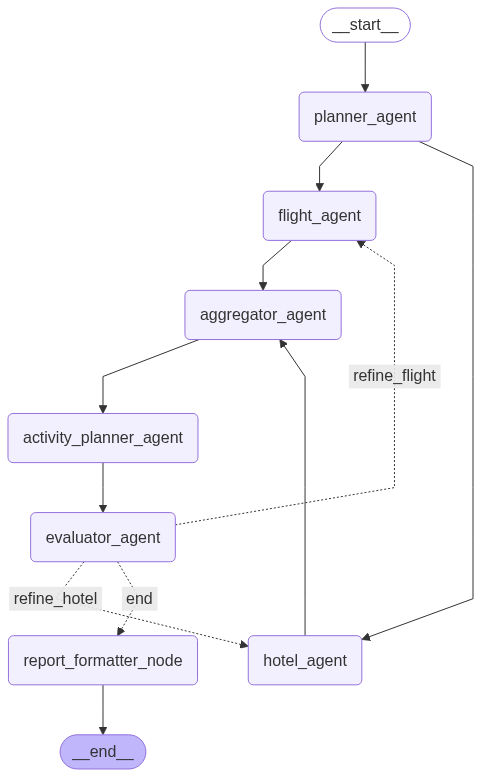

In [1467]:
workflow = StateGraph(TripState)


workflow.add_node("planner_agent", planner_agent)
workflow.add_node("flight_agent", flight_agent)
workflow.add_node("hotel_agent", hotel_agent) 
workflow.add_node("aggregator_agent", aggregator_agent) 
workflow.add_node("activity_planner_agent", activity_planner_agent)
workflow.add_node("evaluator_agent", evaluator_agent)
workflow.add_node("report_formatter_node", report_formatter_node) 


workflow.add_edge(START, "planner_agent")

workflow.add_edge("planner_agent", "flight_agent")
workflow.add_edge("planner_agent", "hotel_agent")

workflow.add_edge("flight_agent", "aggregator_agent")
workflow.add_edge("hotel_agent", "aggregator_agent")

workflow.add_edge("aggregator_agent", "activity_planner_agent")
workflow.add_edge("activity_planner_agent", "evaluator_agent")

workflow.add_conditional_edges(
    "evaluator_agent",
    should_refine_or_end,
    {
        "refine_hotel": "hotel_agent",           
        "refine_flight": "flight_agent",         
        "end": "report_formatter_node"           
    }
)

workflow.add_edge("report_formatter_node", END)


app = workflow.compile()

display(Image(app.get_graph().draw_mermaid_png()))

In [1468]:
user_query = "Plan a trip from Istanbul to Amsterdam between 25.09.2025 and 28.09.2025 with my girlfriend. We are interested in food and entertainment, and our total budget is around 1500 euro."
initial_state = {"user_request": user_query}
final_state = app.invoke(initial_state)

print("\n--- FINAL REPORT ---")

final_markdown_report = final_state.get("markdown_report", "No report was generated.")
display(Markdown(final_markdown_report))

--- Running Planner Agent ---
-> Structured Plan: origin='Istanbul' destination='Amsterdam' start_date='2025-09-25' end_date='2025-09-28' person=2 budget=1500.0 interests=['food', 'entertainment']
--- Running Flight Agent ---
-> Step 1: Finding IATA codes...
--- Calling Booking.com auto-complete API for Istanbul ---
--- Running Hotel Agent ---
-> Step 1: Finding Location ID...
--- Calling Location ID Finder API for Amsterdam ---
-> Found IATA codes for Istanbul: ['IST', 'SAW']
--- Calling Booking.com auto-complete API for Amsterdam ---
-> Found Location ID for Amsterdam: eyJjaXR5X25hbWUiOiJBbXN0ZXJkYW0iLCJjb3VudHJ5IjoiTmV0aGVybGFuZHMiLCJkZXN0X2lkIjoiLTIxNDA0NzkiLCJkZXN0X3R5cGUiOiJjaXR5In0=
-> Step 2: Finding hotel options with the ID...
--- Calling REAL Booking.com Hotel API with Location ID: eyJjaXR5X25hbWUiOiJBbXN0ZXJkYW... ---
-> Found IATA codes for Amsterdam: ['AMS']
-> Step 2: Finding flight options...
--- Calling REAL Flight API for ['IST', 'SAW'] -> ['AMS'] ---
-> Searching fli

# Your Trip to Amsterdam

A 4-day trip for 2 people, focusing on food, entertainment.

## ✈️ Flight Information
- **Airline:** KLM
- **Origin:** Istanbul (IST)
- **Total Price:** €449.49

## 🏨 Hotel Information
- **Hotel Name:** The July - Boat & Co
- **Rating:** 9.2 / 5.0
- **Total Price for Stay:** €931.90

---

## 🗺️ Daily Itinerary

### Day 1
- **Morning: Guided Bike Tour of Amsterdam's Highlights and Hidden Gems**
  - *Guided bike tour*
  - Location: Amsterdam
- **Afternoon: Visit to the Anne Frank House**
  - *Historical landmark*
  - Location: Amsterdam

### Day 2
- **Morning: Canal Boat Tour**
  - *Explore Amsterdam's UNESCO World Heritage canal ring*
  - Location: Amsterdam
- **Afternoon: Visit to the Van Gogh Museum**
  - *Museum visit*
  - Location: Amsterdam

### Day 3
- **Evening: Food Tour at Albert Cuyp Market**
  - *Food tour*
  - Location: Jordaan District, Amsterdam
- **Afternoon: Visit to the Royal Palace Amsterdam**
  - *Historical landmark*
  - Location: Amsterdam

### Day 4
- **Evening: Candlelight Concert**
  - *Musical performance*
  - Location: Amsterdam
- **Morning: Visit to the Flower Market**
  - *Market visit*
  - Location: Amsterdam
